# Import Modules
You may need to install some of them.
But if you activate the environment inside this `examples` folder, all dependencies should be included.

In [1]:
using Pkg
Pkg.instantiate()

## 2D Deconvolution on CUDA GPUs

In [2]:
using Revise, DeconvOptim, TestImages, Noise, CUDA, ImageShow, Colors, FFTW, FourierTools
FFTW.set_num_threads(12)
CUDA.allowscalar(false);

h_view(args...) = begin
    img = cat(args..., dims=2)
    img ./= maximum(img)
    Gray.(img)
end

┌ Info: DeconvOptim.jl: CUDA.jl is loaded, so include GPU functionality
└ @ DeconvOptim /home/fxw/.julia/packages/DeconvOptim/mveIX/src/requires.jl:6
┌ Warning: Replacing module `ImageCore`
└ @ Base loading.jl:1036


h_view (generic function with 1 method)

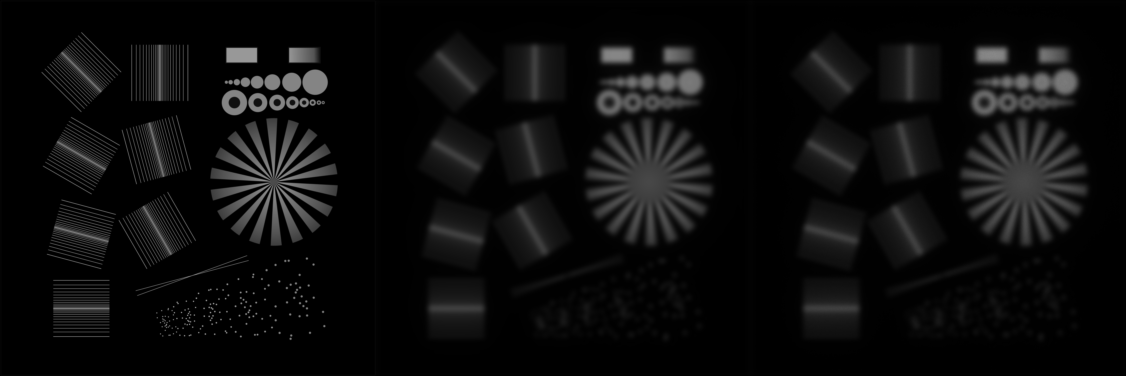

┌ Warning: Replacing module `ImageCore`
└ @ Base loading.jl:1036


In [3]:
# load test images
img = Float32.(testimage("resolution_test_1920"))
img = resample(img, (3000, 3000))
psf = Float32.(generate_psf(size(img), 30))
psf = resample(psf, (3000, 3000))

psf_c = CuArray(psf)
# create a blurred, noisy version of that image
img_b = DeconvOptim.conv(img, psf)
img_n = poisson(img_b, 300);

img_n_c = CuArray(img_n)
h_view(img, img_b, img_n)

In [4]:
reg = TV(mode="forward")

#160 (generic function with 1 method)

In [12]:
@time resG, optim_res = deconvolution(img_n, psf, loss=Poisson(), regularizer=reg, λ=0.005, iterations=20)

 10.745566 seconds (49.47 k allocations: 9.391 GiB, 5.64% gc time)


(Float32[0.041051667 0.040711265 … 0.038898356 0.04021286; 0.040782206 0.04047757 … 0.039216824 0.040135663; … ; 0.03884206 0.038964067 … 0.039014217 0.039666362; 0.039794 0.039466538 … 0.039649136 0.042425286],  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     6.744498e+04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.91e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.48e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.04e+02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.53e-03 ≰ 0.0e+00
    |g(x)|                 = 1.58e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   10  (vs limit Inf)
    Iterations:    20
    f(x) calls:    23
    ∇f(x) calls:   21
)

In [6]:
reg_gpu = TV_cuda(num_dims=2)

#26 (generic function with 1 method)

In [13]:
CUDA.@time resG_c, optim_res_c = deconvolution(img_n_c, psf_c, 
    loss=Poisson(), regularizer=reg_gpu, λ=0.005, iterations=20)

  0.905626 seconds (101.93 k CPU allocations: 6.881 MiB, 3.09% gc time) (1.47 k GPU allocations: 25.741 GiB, 4.84% memmgmt time)


(Float32[0.04050665 0.04050369 … 0.03885263 0.04028039; 0.040237118 0.040156506 … 0.03915393 0.04012804; … ; 0.038734127 0.038973715 … 0.03917845 0.03939419; 0.03995992 0.03896586 … 0.039395902 0.042422146],  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     6.743994e+04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 6.33e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.59e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.05e+02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.55e-03 ≰ 0.0e+00
    |g(x)|                 = 1.56e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    20
    f(x) calls:    23
    ∇f(x) calls:   21
)

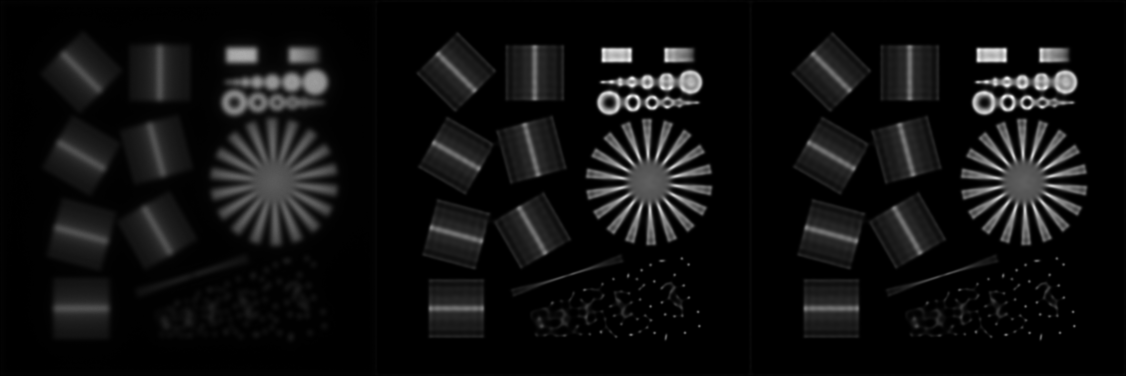

In [8]:
h_view(Array(img_n_c), Array(resG_c), Array(resG))

In [9]:
≈(Array(resG_c) .+ 1, Array(resG) .+ 1, rtol=1f-3)

true